# E16. Super Resolution - SRGAN
- 딥러닝 네트워크를 사용해 저해상도 이미지를 고해상도 이미지로 super resolution하기.
- SRCNN, SRGAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os

print(tf.__version__)

2.6.0


In [3]:
# SRCNN 모델 apply
model_file = '/content/drive/MyDrive/data/e16/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

## SRGAN 모델의 구조

![nn](srgan_gene.png)
![nn](srgan_disc.png)

In [4]:
# SRGAN 모델 구현
from tensorflow.keras import Input, Model, layers

# Generator
# Generator의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# Generator 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

# Discriminator
# 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

In [5]:
# SRGAN loss 계산
from tensorflow.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

In [6]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


# gene_losses = metrics.Mean()
# disc_losses = metrics.Mean()
# 학습에 많은 시간이 소요되므로 이미 학습된 모델을 불러온다.

80150528/80134624 [==============================] - 1s 0us/step


In [7]:
model_file = '/content/drive/MyDrive/data/e16/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

(500, 850, 3)
(500, 850, 3)
(500, 850, 3)


/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


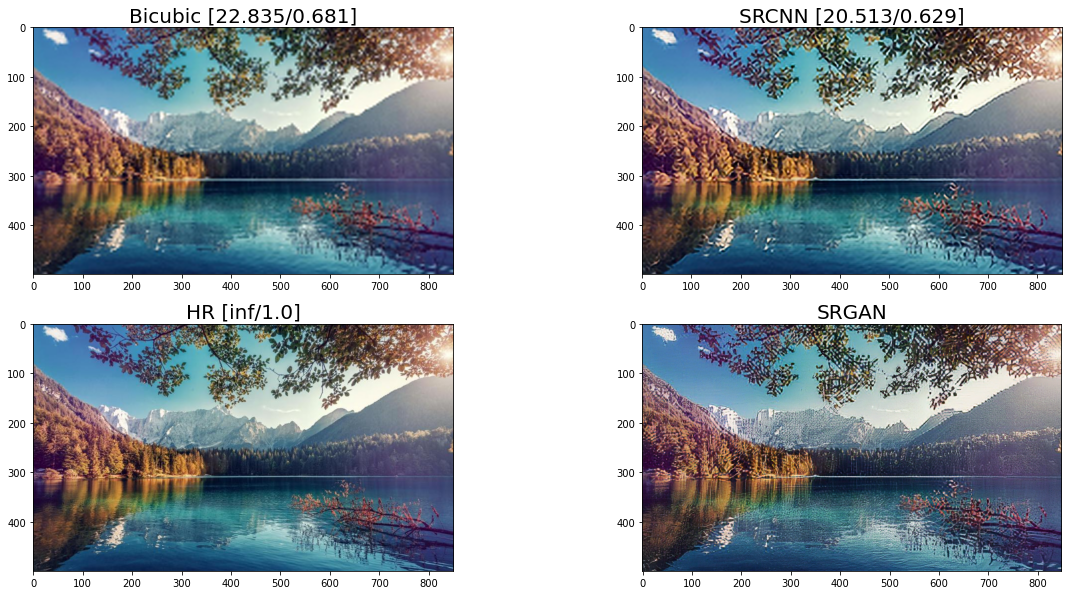

In [8]:
# 프로젝트 1-1
file_path = '/content/drive/MyDrive/data/e16/nature.jpeg'
hr_img = cv2.imread(file_path)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
lr_img = cv2.resize(hr_img, (hr_img.shape[1]//4, hr_img.shape[0]//4))

bicubic_hr = cv2.resize(lr_img, (hr_img.shape[1], hr_img.shape[0]),
                    interpolation=cv2.INTER_CUBIC)
srgan_img = apply_srgan(lr_img)
srcnn_img = apply_srcnn(bicubic_hr)

images = [bicubic_hr, srcnn_img, hr_img]
titles = ['Bicubic', 'SRCNN', 'HR']

for i in images:
    print(i.shape)

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_img, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_img, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)

    if i ==3:
        plt.imshow(srgan_img)
        plt.title('SRGAN', fontsize=20)
    else:
        plt.imshow(images[i])
        plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

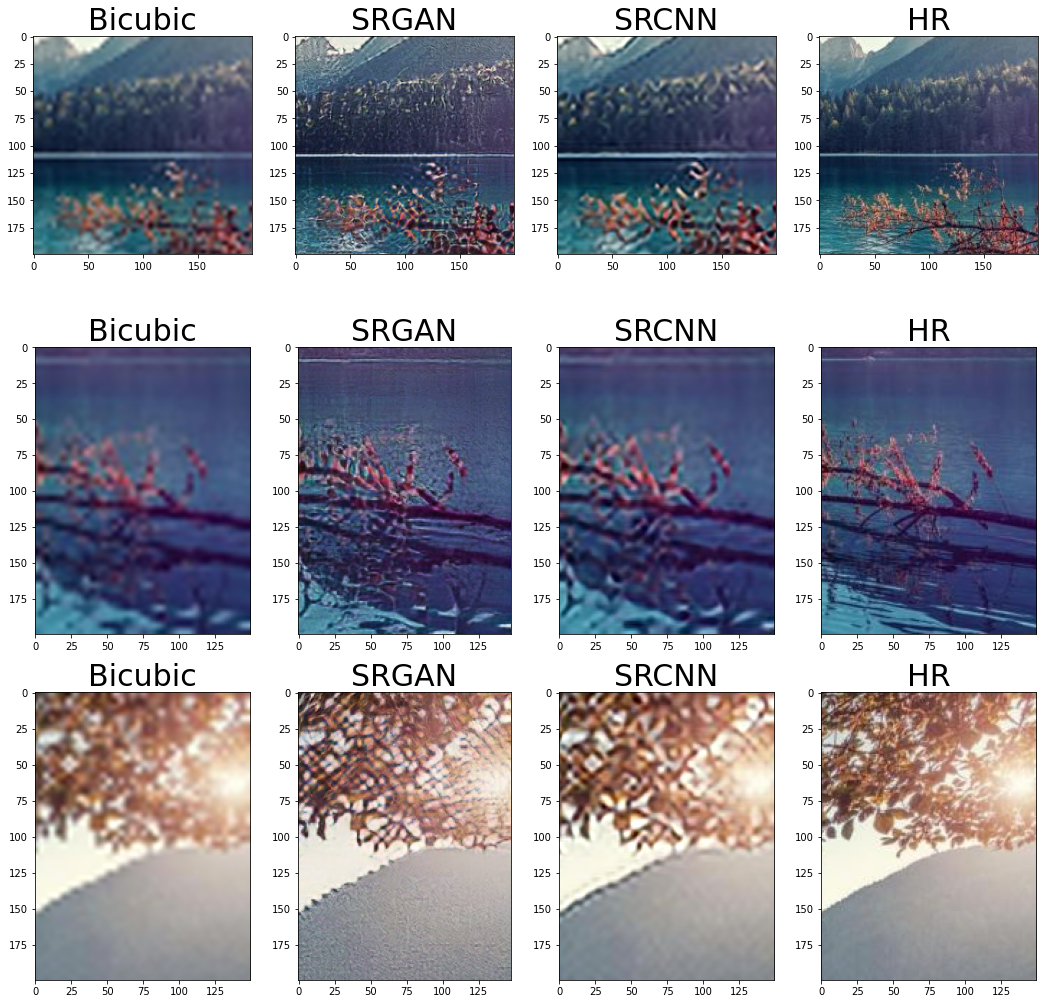

In [9]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,500), (300,700), (0,700)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_img , left_top, 200, 200)
    img3 = crop(srcnn_img , left_top, 200, 200)
    img4 = crop(hr_img, left_top, 200, 200)
    images.extend([img1, img2, img3, img4])

labels = ["Bicubic", "SRGAN", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(12):
    plt.subplot(3,4,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

(172, 293, 3)


Text(0.5, 1.0, 'HR')

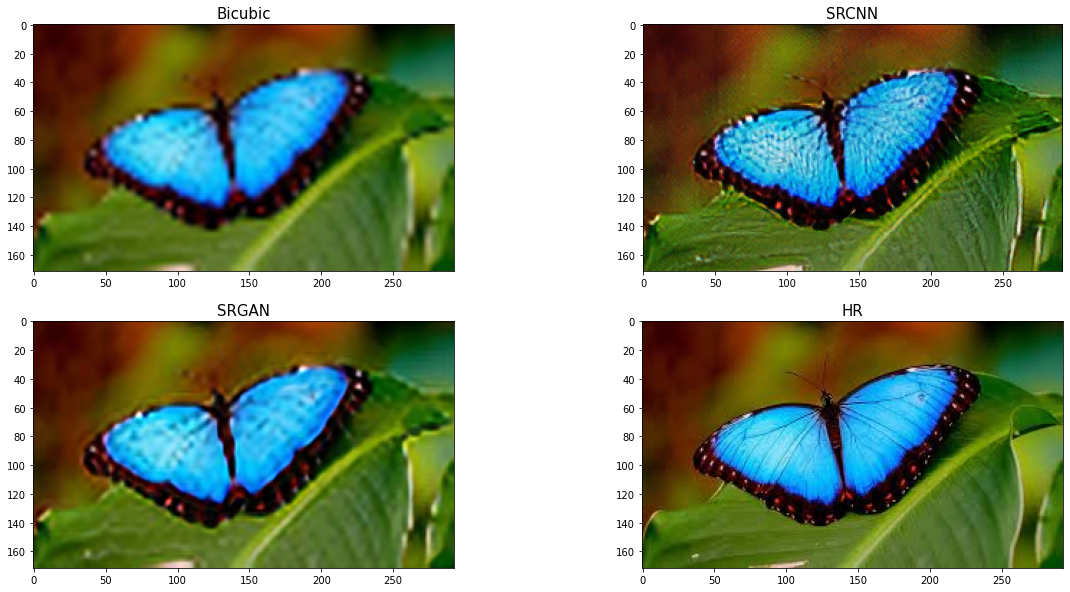

In [10]:
file_path = '/content/drive/MyDrive/data/e16/butterfly.jpeg'
hr_img = cv2.imread(file_path)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
print(hr_img.shape)

hr_img_np = np.array(hr_img)
lr_img = cv2.resize(hr_img_np, (hr_img_np.shape[1]//4, hr_img_np.shape[0]//4))
bicubic_hr = cv2.resize(lr_img, (hr_img_np.shape[1], hr_img_np.shape[0]),
                    interpolation=cv2.INTER_CUBIC)

srgan_img = apply_srgan(lr_img)
srcnn_img = apply_srcnn(bicubic_hr)

plt.figure(figsize=(20,10))
plt.subplot(221); plt.imshow(bicubic_hr); plt.title("Bicubic", fontsize=15)
plt.subplot(222); plt.imshow(srgan_img); plt.title("SRCNN", fontsize=15)
plt.subplot(223); plt.imshow(srcnn_img); plt.title("SRGAN", fontsize=15)
plt.subplot(224); plt.imshow(hr_img); plt.title("HR", fontsize=15)

**알게된 사실**
- Bicubic interpolation 으로 super resolution을 한 경우는 매우 흐릿하다.
- DIV2K 데이터셋이 주로 자연물이라고 하여 자연 사진을 가져왔다. 위의 풍경 사진에서는 SRCNN과 SRGAN 비슷한 수준으로 super resolution 된 것 같으며 (눈으로 봤을 때) 고해상도 이미지에는 미치지 못하고 있다. 점묘화 같은 느낌이다.
- 이미지 사이즈가 작은 경우 super resolution이 어려움

(321, 481, 3)


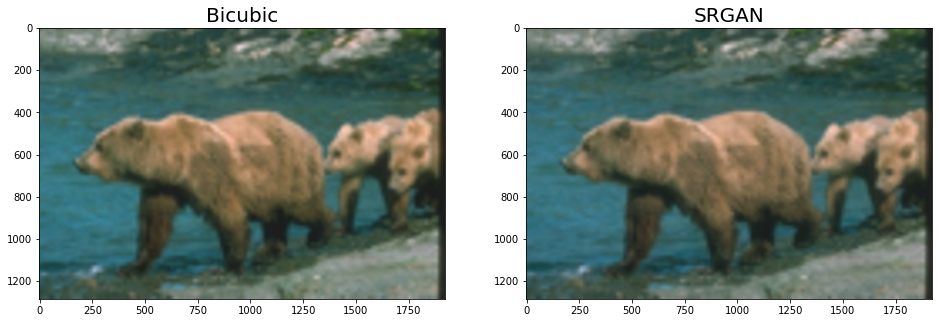

In [11]:
# 프로젝트 1-2
file_path = '/content/drive/MyDrive/data/e16/lr.jpeg'
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

srgan_img = apply_srgan(img)
bicubic_img = cv2.resize(img, (img.shape[1] * 4, img.shape[0] * 4),
                        interpolation=cv2.INTER_CUBIC)

images = [bicubic_img, srgan_img]
labels = ['Bicubic', 'SRGAN']

plt.figure(figsize=(16,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=20)

In [ ]:
file_path = '/content/drive/MyDrive/data/e16/lr.jpeg'
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

srgan_img = apply_srgan(img)
bicubic_img = cv2.resize(img, (img.shape[1] * 4, img.shape[0] * 4),
                        interpolation=cv2.INTER_CUBIC)

images = [bicubic_img, srgan_img]
labels = ['Bicubic', 'SRGAN']

plt.figure(figsize=(16,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=20)

In [12]:
!pip install imageio

In [13]:
# 다운받은 파일의 경로를 설정해 주세요.
file_path = '/content/drive/MyDrive/data/e16/metro_lr.gif'
gif = cv2.VideoCapture(file_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 35
frame 크기 : (252, 282, 3)


In [14]:
frames_bicubic = []
frames_srgan = []

for frame in frames:
    bicubic_frame = cv2.resize(frame, (frame.shape[1]*4, frame.shape[0]*4),
                               interpolation=cv2.INTER_CUBIC)
    frames_bicubic.append(bicubic_frame)
    
    srgan_frame = apply_srgan(frame)
    frames_srgan.append(srgan_frame)

import imageio
imageio.mimsave("/content/drive/MyDrive/data/e16/hr_bicubic.gif", frames_bicubic)
imageio.mimsave("/content/drive/MyDrive/data/e16/hr_srgan.gif", frames_srgan)

In [15]:
from IPython.display import Image as show_gif

show_gif("/content/drive/MyDrive/data/e16/hr_bicubic.gif", width=800)

ValueError: ignored

- 깃헙에 gif 파일 업로드

![SegmentLocal](metro_lr.gif "segment")
![SegmentLocal](hr_srgan.gif "segment")
![SegmentLocal](hr_bicubic.gif "segment")
